![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 15 - Interpretability</center>
### <center> ELI5 and LIME <center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/15_Interpretability/MainELIandLIME.ipynb)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install eli5
    !pip install lime

### Load the Titanic dataset:

In [4]:
from sklearn.datasets import fetch_openml

lClasses          = ['Died', 'Survived']
dData, vY         = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
dData['Survived'] = vY

dData.drop(columns=['name', 'ticket', 'cabin', 'boat', 'home.dest', 'body'], inplace=True)
dData

,pclass,sex,age,sibsp,parch,fare,embarked,Survived
0,1.0,female,29.0000,0.0,0.0,211.3375,S,1
1,1.0,male,0.9167,1.0,2.0,151.5500,S,1
2,1.0,female,2.0000,1.0,2.0,151.5500,S,0
3,1.0,male,30.0000,1.0,2.0,151.5500,S,0
4,1.0,female,25.0000,1.0,2.0,151.5500,S,0
...,...,...,...,...,...,...,...,...
1304,3.0,female,14.5000,1.0,0.0,14.4542,C,0
1305,3.0,female,NaN,1.0,0.0,14.4542,C,0
1306,3.0,male,26.5000,0.0,0.0,7.2250,C,0
1307,3.0,male,27.0000,0.0,0.0,7.2250,C,0


#### Fill NaNs:
* Categorigal data can be filled with the most frequent value (mode).
* Numerical data can be filled with the median (or average).

In [5]:
#-- col : value
dNaNs = {
    'embarked' : dData['embarked'].mode()[0],
    'age'      : dData['age']     .median(),
    'fare'     : dData['fare']    .median(),
}

dData.fillna(value=dNaNs, inplace=True)
dData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   sex       1309 non-null   category
 2   age       1309 non-null   float64 
 3   sibsp     1309 non-null   float64 
 4   parch     1309 non-null   float64 
 5   fare      1309 non-null   float64 
 6   embarked  1309 non-null   category
 7   Survived  1309 non-null   category
dtypes: category(3), float64(5)
memory usage: 55.5 KB


#### Use dummy variables for categorical columns:

In [6]:
dData = pd.get_dummies(dData, drop_first=True)
dData

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Survived_1
0,1.0,29.0000,0.0,0.0,211.3375,0,0,1,1
1,1.0,0.9167,1.0,2.0,151.5500,1,0,1,1
2,1.0,2.0000,1.0,2.0,151.5500,0,0,1,0
3,1.0,30.0000,1.0,2.0,151.5500,1,0,1,0
4,1.0,25.0000,1.0,2.0,151.5500,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1304,3.0,14.5000,1.0,0.0,14.4542,0,0,0,0
1305,3.0,28.0000,1.0,0.0,14.4542,0,0,0,0
1306,3.0,26.5000,0.0,0.0,7.2250,1,0,0,0
1307,3.0,27.0000,0.0,0.0,7.2250,1,0,0,0


In [7]:
mX        = dData.drop(columns=['Survived_1']).values
vY        = dData['Survived_1'].values
lFeatures = list(dData.columns)[:-1]

mX.shape, vY.shape

((1309, 8), (1309,))

# ELI5
For trees on linear models

#### Train models:

In [8]:
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#-- Train tree:
oTree = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6).fit(mX, vY)
#-- Train logistic regression:
oLR   = LogisticRegression(max_iter=1000).fit(mX, vY)

print(f'Tree:                train accuracy = {100*oTree.score(mX, vY):6.2f}%')
print(f'Logistic regression: train accuracy = {100*oLR.  score(mX, vY):6.2f}%')

Tree:                train accuracy =  81.67%
Logistic regression: train accuracy =  78.99%


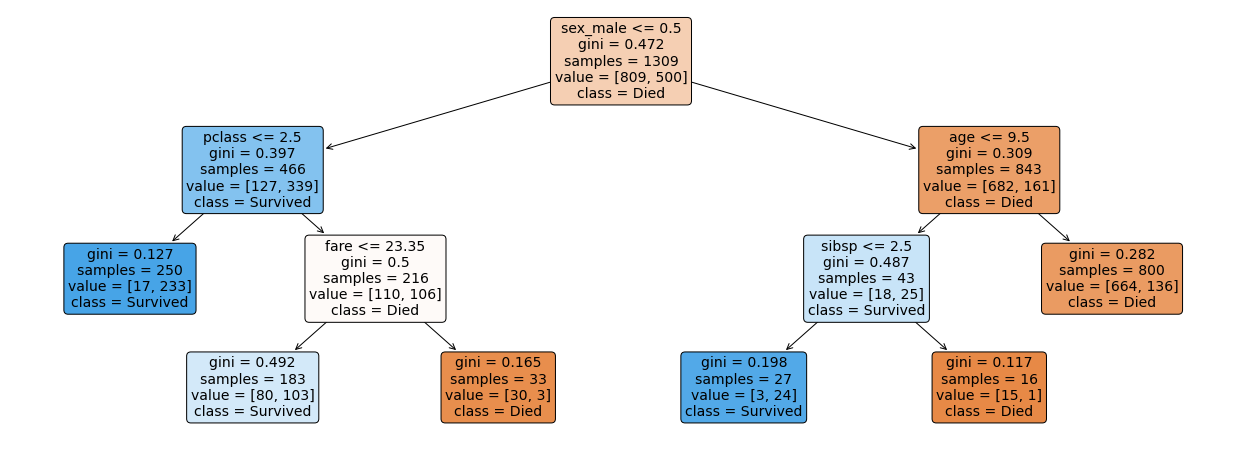

In [9]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(22, 8))
plot_tree(oTree, filled=True, rounded=True, fontsize=14, feature_names=lFeatures, ax=ax, class_names=lClasses)
plt.show()

#### ELI5 with trees
Feature importance using Mean Decrease in Impurity

In [10]:
import eli5

eli5.show_weights(oTree, target_names=lClasses, feature_names=lFeatures)

Weight,Feature
0.6699,sex_male
0.1750,pclass
0.0536,age
0.0532,sibsp
0.0483,fare
0,embarked_S
0,embarked_Q
0,parch


#### ELI5 with linear models
feature importance based on the model's weights

In [11]:
eli5.show_weights(oLR, target_names=lClasses, feature_names=lFeatures)

Weight?,Feature
+4.756,<BIAS>
+0.002,fare
-0.018,parch
-0.035,age
-0.300,sibsp
-0.457,embarked_Q
-0.560,embarked_S
-0.953,pclass
-2.529,sex_male


# LIME

### Tabular data

In [12]:
from lime.lime_tabular import LimeTabularExplainer

oLimeTable = LimeTabularExplainer(
    mX,
    discretize_continuous = True,
    feature_names         = lFeatures,
    class_names           = lClasses,
    verbose               = True
)

#### Choosing an instance:

In [13]:
idx = 4
vX  = mX[idx,:]
dData.loc[idx,:]

pclass          1.00
age            25.00
sibsp           1.00
parch           2.00
fare          151.55
sex_male        0.00
embarked_Q      0.00
embarked_S      1.00
Survived_1      0.00
Name: 4, dtype: float64

#### Apply LIME to the linear model around the specific instance `vX`:

In [14]:
oExp = oLimeTable.explain_instance(vX, oLR.predict_proba)
oExp.show_in_notebook(show_table=True, show_all=True)

Intercept 0.09599733355902118
Prediction_local [0.81512796]
Right: 0.9053531401240437


#### Apply LIME to a random forest:

In [15]:
from sklearn.ensemble import RandomForestClassifier

oRF = RandomForestClassifier(oob_score=True).fit(mX, vY)
oRF.oob_score_

0.7929717341482048

In [16]:
oExp = oLimeTable.explain_instance(vX, oRF.predict_proba)
oExp.show_in_notebook(show_table=True, show_all=True)

Intercept 0.24465077269318045
Prediction_local [0.73028437]
Right: 0.3


### Question:
Why the local prediction (`Prediction_local`) is so different from the model prediction (`Right`)?

In [17]:
oRF.oob_decision_function_[idx,:]

array([0.23076923, 0.76923077])

### LIME with Images
using a pre-trained DNN model

In [18]:
#-- Import PyTorch:
import torch
import torch.nn.functional    as F
import torchvision
import torchvision.transforms as transforms
import json

#### Model and prediction function:

In [19]:
#-- Use a pretrained deep learning model:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
oModel = torchvision.models.resnet50(pretrained=True).eval()
oModel.to(DEVICE) #-- use GPU if available 

#-- model's labels:
dClasses = json.load(open('imagenet_class_index.json'))
lClasses = [dClasses[str(k)][1] for k in range(1000)]

#==================================================================================
#==================================================================================
#-- Model's prediction function:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

def PredictBatch(lImages):
    #-- Transforms:
    oTransforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=vMean, std=vStd),
    ])

    #-- Predict images:
    oModel.eval()
    mX = torch.stack([oTransforms(mI) for mI in lImages], dim=0)
    with torch.no_grad():
        mZ = oModel(mX.to(DEVICE))
    mP = F.softmax(mZ, dim=1)
    return mP.cpu().numpy()

#### Load images:

In [20]:
#-- Load an image:
from PIL import Image
import urllib

def GetImageFromUrl(url):
    fileName = '__TempImage__.jpg'
    try:
        urllib.URLopener().retrieve(url, fileName)
    except:
        urllib.request.urlretrieve(url, fileName)
    
    oImage = Image.open(fileName)
    mI     = np.array(oImage)
    oImage.close()
    return mI

def GetImageFromPath(fileName):
    oImage = Image.open(fileName).convert('RGB')
    mI     = np.array(oImage)
    oImage.close()
    return mI

#-- Some images URL:
lUrls = [
    'https://farm3.static.flickr.com/2278/2096798034_bfe45b11ee.jpg',
    'https://static.flickr.com/48/116936482_7458bb78c1.jpg',
    'https://farm4.static.flickr.com/3001/2927732866_3bd24c2f98.jpg',
    'https://farm4.static.flickr.com/3018/2990729221_aabd592245.jpg',
    'https://farm4.static.flickr.com/3455/3372433349_0444709b8f.jpg',
    'https://i.huffpost.com/gen/3113902/thumbs/o-CAT-ON-LEASH-570.jpg?1',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg'
]

#### Import LIME:

In [21]:
from lime                 import lime_image
from skimage.segmentation import mark_boundaries

oLimeImage = lime_image.LimeImageExplainer()

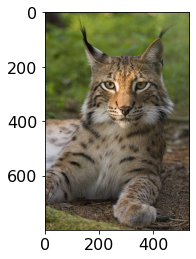

In [22]:
if 'google.colab' in str(get_ipython()):
    mI = GetImageFromUrl(lUrls[6])
else:
    mI = GetImageFromPath('Lynx0001.jpg')
plt.imshow(mI)
plt.show()

#### Apply LIME to image:

In [23]:
oExp = oLimeImage.explain_instance(mI,                  
                                   PredictBatch,
                                   top_labels   = 1,
                                   num_samples  = 1000,
                                   batch_size   = 128)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Or\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#### Top predictions:

In [24]:
[lClasses[ll] for ll in oExp.top_labels]

['lynx']

#### Show explanation:

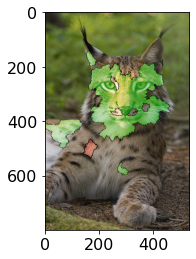

In [25]:
mLimeExp, mMask = oExp.get_image_and_mask(oExp.top_labels[0], positive_only=False, num_features=30, hide_rest=False)
mLimeExp        = (.5 * mLimeExp + .5 * mI).astype(int)
mExpI           = mark_boundaries(mLimeExp/255.0, mMask, color=(0,0,0))
plt.imshow(mExpI)
plt.show()